In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Loading data

In [2]:
data = pd.read_csv('steamUsers.csv', sep=',')


### Nettoyage 

In [3]:
#Removed the useless 0 column 
data = data.drop('0', 1)
nRawRows = data.shape[0]

In [4]:
#Removed duplicates
data.drop_duplicates(subset=None, keep="first", inplace=True)
print(nRawRows, "rows before removing duplicates")
nRows = data.shape[0]
print(nRows, "rows after removing duplicates")

200000 rows before removing duplicates
199293 rows after removing duplicates


### Purchased without playing

In [5]:
nonPlayedGames = pd.DataFrame(data)
nonPlayedGames.drop_duplicates(subset=['gamerId','gameName'], keep=False, inplace=True)
nNPlayed = nonPlayedGames.shape[0]
print(nNPlayed, "games were purchased but never played")
d = {1.0:0.5}
nonPlayedGames = nonPlayedGames.replace(d)
nonPlayedGames = nonPlayedGames.drop('Action', 1)
nonPlayedGames.head(6)

58327 games were purchased but never played


,gamerId,gameName,playHours
52,151603712,Alan Wake,0.5
53,151603712,BioShock 2,0.5
54,151603712,Fallen Earth,0.5
55,151603712,Fallout New Vegas Courier's Stash,0.5
56,151603712,Fallout New Vegas Dead Money,0.5
57,151603712,Fallout New Vegas Honest Hearts,0.5


### Purchased and played

In [6]:
playCheck = data.Action.str.contains('play') 
playedGames = data[playCheck] 
nplayed = playedGames.shape[0]
print(nplayed, "games were purchased and played")
playedGames = playedGames.drop('Action', 1)
playedGames.head(6)
print(playedGames.shape)

70489 games were purchased and played
(70489, 3)


### Final dataset

In [7]:
frames = [playedGames, nonPlayedGames]

result = pd.concat(frames,ignore_index=True)
result.sort_values(by=['gamerId', 'gameName'])
result.head(6)


,gamerId,gameName,playHours
0,151603712,The Elder Scrolls V Skyrim,273.0
1,151603712,Fallout 4,87.0
2,151603712,Spore,14.9
3,151603712,Fallout New Vegas,12.1
4,151603712,Left 4 Dead 2,8.9
5,151603712,HuniePop,8.5


### Load games data

In [8]:
gamesData = pd.read_csv('steamGames.csv', sep=',')
gamesData.rename(columns={'name': 'gameName'}, inplace=True)
gamesData.head(6)

,appid,gameName,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99
5,60,Ricochet,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Valve Anti-Ch...,Action,Action;FPS;Multiplayer,0,2758,684,175,10,5000000-10000000,3.99


In [9]:
#result = result.merge(gamesData[['gameName','appid','release_date','developer','publisher','categories','genres','steamspy_tags','positive_ratings','negative_ratings','average_playtime','median_playtime','price']], how='left', on='gameName')

result = result.merge(gamesData[['gameName','appid']], how='left', on='gameName')

result.dropna(inplace=True)
result.head(5)

,gamerId,gameName,playHours,appid
1,151603712,Fallout 4,87.0,377160.0
4,151603712,Left 4 Dead 2,8.9,550.0
5,151603712,HuniePop,8.5,339800.0
6,151603712,Path of Exile,8.1,238960.0
7,151603712,Poly Bridge,7.5,367450.0


In [10]:
result.astype({'appid': 'int64'}).dtypes
result.head(5)



,gamerId,gameName,playHours,appid
1,151603712,Fallout 4,87.0,377160.0
4,151603712,Left 4 Dead 2,8.9,550.0
5,151603712,HuniePop,8.5,339800.0
6,151603712,Path of Exile,8.1,238960.0
7,151603712,Poly Bridge,7.5,367450.0


# Load tags data

In [11]:
tagsData = pd.read_csv('steamsGamesTags.csv', sep=',')
#gamesData.rename(columns={"name": "gameName"}, inplace=True)
tagsData.head(6)

,appid,1980s,1990s,2.5d,2d,2d_fighter,360_video,3d,3d_platformer,3d_vision,...,warhammer_40k,web_publishing,werewolves,western,word_game,world_war_i,world_war_ii,wrestling,zombies,e_sports
0,10,144,564,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,550
1,20,0,71,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,5,122,0,0,0
3,40,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,50,0,77,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,60,0,0,0,0,0,0,13,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
result = result.merge(tagsData, how='left', on='appid')

#result.dropna(inplace=True)
result.head(9)



,gamerId,gameName,playHours,appid,1980s,1990s,2.5d,2d,2d_fighter,360_video,...,warhammer_40k,web_publishing,werewolves,western,word_game,world_war_i,world_war_ii,wrestling,zombies,e_sports
0,151603712,Fallout 4,87.0,377160.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,151603712,Left 4 Dead 2,8.9,550.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5334,0
2,151603712,HuniePop,8.5,339800.0,0,0,0,95,0,0,...,0,0,0,0,0,0,0,0,0,0
3,151603712,Path of Exile,8.1,238960.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,151603712,Poly Bridge,7.5,367450.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,151603712,Left 4 Dead,3.3,500.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1064,0
6,151603712,Team Fortress 2,2.8,440.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,151603712,Tomb Raider,2.5,203160.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,151603712,The Banner Saga,2.0,237990.0,0,0,0,99,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
gamerTags = result.drop(['gameName','appid'], axis=1)
attr = gamerTags.columns.tolist()
attr.remove('playHours')
attr.remove('gamerId')
#gamerTags[attr] = gamerTags[attr].mul(gamerTags['playHours'], axis=0)

gamerTags = (gamerTags
         .groupby(by='gamerId')
         .mean())

gamerTags = gamerTags.drop(['playHours'], axis=1)
gamerTags



,1980s,1990s,2.5d,2d,2d_fighter,360_video,3d,3d_platformer,3d_vision,4_player_local,...,warhammer_40k,web_publishing,werewolves,western,word_game,world_war_i,world_war_ii,wrestling,zombies,e_sports
gamerId,,,,,,,,,,,,,,,,,,,,,
5250,12.000000,84.250000,0.0,0.000000,0.0,0.0,1.083333,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.416667,10.166667,0.0,50.583333,443.166667
76767,11.076923,78.769231,0.0,4.846154,0.0,0.0,1.000000,0.0,4.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.384615,9.384615,0.0,7.461538,42.307692
86540,5.760000,40.440000,0.0,1.240000,0.0,0.0,0.520000,0.0,3.52,0.0,...,0.0,0.0,0.0,0.0,0.0,0.200000,4.880000,0.0,241.520000,22.000000
103360,24.000000,168.500000,0.0,0.000000,0.0,0.0,2.166667,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.833333,20.333333,0.0,0.000000,91.666667
144736,24.000000,168.500000,0.0,0.000000,0.0,0.0,2.166667,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.833333,20.333333,0.0,0.000000,91.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309404240,0.000000,0.000000,0.0,89.000000,0.0,0.0,0.000000,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,3084.500000,0.000000
309434439,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,4768.000000
309812026,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000


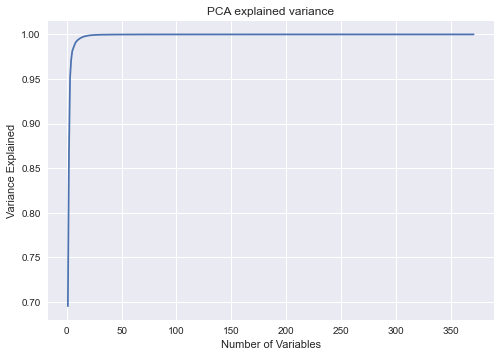

In [14]:
pca = PCA()
pca.fit(gamerTags)

acc_var = np.cumsum(pca.explained_variance_ratio_) 

plt.style.use('seaborn')
plt.plot(range(1, len(acc_var)+1), acc_var)
plt.title('PCA explained variance')
plt.xlabel('Number of Variables')
_ = plt.ylabel('Variance Explained')

In [15]:
number_of_components = 50
pca.set_params(n_components=number_of_components)
pca.fit(gamerTags)
gamers_pca = pca.transform(gamerTags)
gamers_pos_pca = pd.DataFrame(gamers_pca)
gamers_pos_pca['gamerId'] = gamerTags.index
gamers_pos_pca = gamers_pos_pca.set_index('gamerId')
gamers_pos_pca.head(1)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
gamerId,,,,,,,,,,,,,,,,,,,,,
5250,-9837.337426,-2350.738478,-1453.227379,-280.920606,-282.885427,-63.916211,-231.463137,-84.270295,523.966092,1.249591,...,18.600124,-33.054472,1.525643,27.917043,-20.037959,-4.200659,-6.256543,15.005849,-15.137825,-0.32455


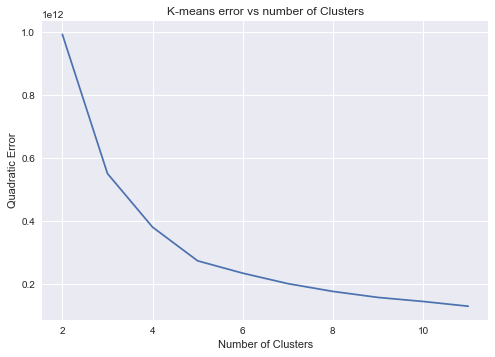

In [16]:
inertia = []
scores = []
for n_clusters in range(2, 12):
    kmeans = KMeans(n_clusters=n_clusters, n_jobs=-1)
    kmeans.fit(gamers_pos_pca)
    inertia.append(kmeans.inertia_)
plt.plot(range(2, 12), inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Quadratic Error')
_ = plt.title('K-means error vs number of Clusters')

In [17]:
gamers_with_label = pd.DataFrame(PCA(n_components=3).fit_transform(gamerTags))
gamers_with_label['gamerId'] = gamerTags.index
gamers_with_label = gamers_with_label.set_index('gamerId')

kmeans = KMeans(n_clusters=6, n_init=30, n_jobs=-1)
gamers_with_label['label'] = kmeans.fit_predict(gamers_pos_pca)
gamers_with_label.head()

,0,1,2,label
gamerId,,,,
5250,-9837.337426,-2350.738478,-1453.227379,0
76767,-14078.514213,-4237.705789,-457.252890,0
86540,-14123.908131,-3942.400198,-472.446039,0
103360,-14142.119156,-4341.353562,-760.051133,0
144736,-14142.119156,-4341.353562,-760.051133,0


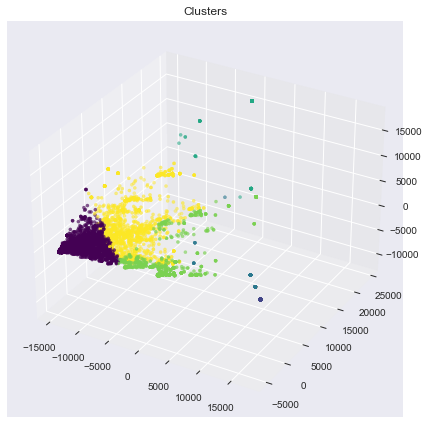

In [18]:
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(gamers_with_label[0], gamers_with_label[1], gamers_with_label[2], c=gamers_with_label['label'].to_numpy(), cmap='viridis', s=10)
_ = plt.title('Clusters')

In [19]:
clustersMembers = {}
for idx, val in (pd.get_dummies(gamers_with_label['label'])).sum().iteritems():
    clustersMembers[idx] = val

for p in clustersMembers:
    print("Cluster", p,"has",clustersMembers[p],"gamers")

Cluster 0 has 3850 gamers
Cluster 1 has 3148 gamers
Cluster 2 has 786 gamers
Cluster 3 has 304 gamers
Cluster 4 has 678 gamers
Cluster 5 has 1355 gamers


### recommandation